In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eust
import intersection
import settings
import nuts
import fadn
import plots

# Prepare some plotting functions

In [2]:
def plot_rate_choropleth(rate, geo, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    plots.plot_europe_choropleth(
        geo[['geometry']].join(rate.rename('rate'), how='inner'),
        'rate',
        bin_uls=plots.CHOROPLETH_KWS['mineral']['bin_uls'],
        cmap=plots.CHOROPLETH_KWS['mineral']['cmap'],
        legend=legend,
        ax=ax,
        legend_kws={'bbox_to_anchor': [1, 1], 'loc': 'upper left', 'frameon': False},
    )
    
    if legend:
        ax.get_legend().set_title('Rate [kg/ha]')

In [3]:
AXES_W, AXES_H = 3, 3 # default size
def plot_multiple(datasets, nrows=1, ncols=None, w=AXES_W, h=AXES_H):
    if ncols is None:
        ncols = len(datasets)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(AXES_W * ncols, AXES_H * nrows))
    
    datasets_gen = (d for d in datasets)
    
    for i in range(nrows):
        for j in range(ncols):
            d = next(datasets_gen)
            ax = axs[i][j] if nrows > 1 else axs[j]
            plot_rate_choropleth(
                rate=d['rate'],
                geo=d['geo'],
                ax=ax,
                legend=(i == 0 and j == ncols - 1), # legend only on top right axes
            )
            
            ax.set_title(d.get('title', None))

    return fig

# Load NUTS regions GIS data

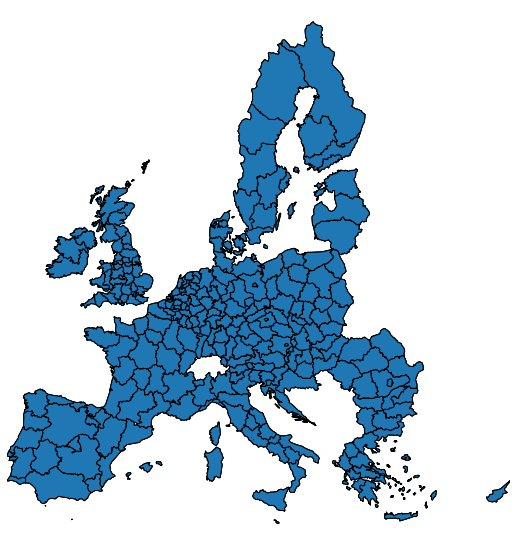

In [4]:
nuts_table = nuts.get_nuts_candidates()
candidate_nuts_regions = nuts_table.index
nuts_geo = (
    geopandas
    .read_file(settings.NUTS_GIS_PATH)
    .set_index('NUTS_ID')
    .reindex(candidate_nuts_regions)
)
ax = nuts_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN regions

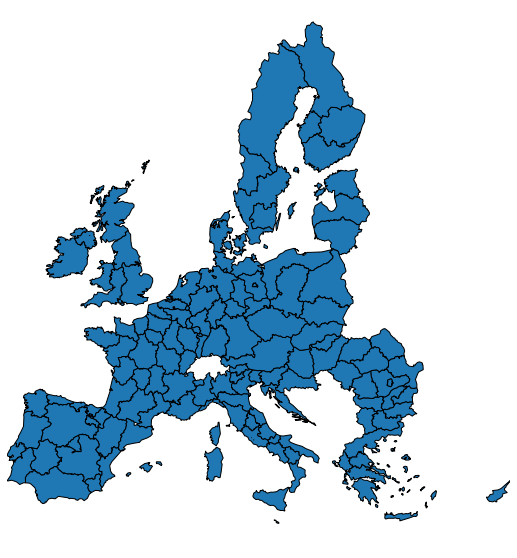

In [5]:
fadn_geo = (
    geopandas
    .read_file(settings.FADN_GIS_PATH)
    .set_index('FADN_2012_')
    [["geometry"]]
)
ax = fadn_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load Eurostat UAA

In [6]:
uaa = (
    eust
    .read_table_data('ef_lus_allcrops')
    .value
    .xs('HA', level='unit')
    .xs('UAA', level='crops')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .mul(1e-6) # to Mha
    .pipe(nuts.fill_nuts)
)
uaa

geo
AT      2.72689
AT1     1.09884
AT11    0.18197
AT12    0.90885
AT13    0.00802
         ...   
UKM3    0.79834
UKM5    0.47877
UKM6    2.76356
UKN     1.04614
UKN0    1.04614
Name: value, Length: 427, dtype: float64

# Extract subnational data from Eurostat `aei_fm_usefert` table

In [7]:
usefert = (
    eust
    .read_table_data('aei_fm_usefert', version='2019-04-30 11:00:00')
    .value
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e-3) # to Gg P
    .pipe(nuts.fill_nuts)
    .rename('usefert')
)

# Extract data from the chosen data year

Asserting that the coverage of subnational data is maximal in the chosen data year, so we do not lose anything by extracting data only from the chosen data year.

In [8]:
usefert_chosen_year = (
    usefert
    .xs(settings.DATA_YEAR, level='time')
    .reindex(candidate_nuts_regions)
    .dropna()
)

usefert_mean_value = (
    usefert
    .groupby('geo')
    .mean()
    .reindex(candidate_nuts_regions)
    .dropna()
)

assert set(usefert_chosen_year.index) == set(usefert_mean_value.index)

# Calculate rate per hectare UAA

usefert_quantity = usefert_chosen_year

usefert_rate = (
    usefert_chosen_year
    .div(uaa) # Gg / Mha = kg / ha
    .dropna()
    .rename('rate')
)

## Plot and inspect usefert data on NUTS 0, 1, 2 levels

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


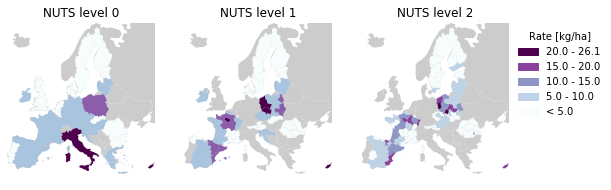

In [9]:
fig = plot_multiple(
    [
        dict(
            rate=nuts.filter_nuts_level(usefert_rate, nuts_level),
            geo=nuts_geo,
            title=f'NUTS level {nuts_level}',
        )
        for nuts_level in [0, 1, 2]    
    ]
)

# Check which countries are covered by NUTS2 level data

In [10]:
nuts2_covered = (
    usefert_rate
    .dropna()
    .to_frame()
    .join(nuts_table)
    .loc[lambda d: d.nuts_level==2]
    .country
    .sort_values()
    .unique()
)

display(', '.join(nuts2_covered))
display(len(nuts2_covered))

'Austria, Cyprus, Czech Republic, Estonia, Finland, France, Latvia, Lithuania, Luxembourg, Malta, Poland, Romania, Slovakia, Spain, Sweden'

15

# Load FADN data

In [11]:
fadn_data = fadn.read_fadn_data('YEAR.COUNTRY.REGION')
fadn_data

SYS02  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             23150   
                                 343         Wallonie               12380   
     CYP          Cyprus         740         Cyprus                 14270   
     CZE          Czech Republic 745         Czech Republic         15930   
     DAN          Denmark        370         Denmark                33850   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  21680   
                                 413         England - West Region  20700   
                                 421         Wales                  10140   
                                 431         Scotland               13140   
                                 441         Northern Ireland       14880   

                                                                           SYS03  \
year country_code country_name   region_code region_name                           
2004 BEL          Belgium        341         Vlaanderen              500 - <1000   
                                 343         Wallonie                500 - <1000   
     CYP          Cyprus         740         Cyprus                   200 - <500   
     CZE          Czech Republic 745         Czech Republic         1000 - <2000   
     DAN          Denmark        370         Denmark                1000 - <2000   
...                                                                          ...   
2017 UKI          United Kingdom 412         England - East Region   500 - <1000   
                                 413         England - West Region   500 - <1000   
                                 421         Wales                    200 - <500   
                                 431         Scotland                 200 - <500   
                                 441         Northern Ireland         200 - <500   

                                                                       SYS04  \
year country_code country_name   region_code region_name                       
2004 BEL          Belgium        341         Vlaanderen             40.33990   
                                 343         Wallonie               40.33990   
     CYP          Cyprus         740         Cyprus                  0.58192   
     CZE          Czech Republic 745         Czech Republic         31.90567   
     DAN          Denmark        370         Denmark                 7.43990   
...                                                                      ...   
2017 UKI          United Kingdom 412         England - East Region   0.88200   
                                 413         England - West Region   0.88200   
                                 421         Wales                   0.88200   
                                 431         Scotland                0.88200   
                                 441         Northern Ireland        0.88200   

                                                                    SE005  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             206.4   
                                 343         Wallonie               155.1   
     CYP          Cyprus         740         Cyprus                  47.1   
     CZE          Czech Republic 745         Czech Republic         232.3   
     DAN          Denmark        370         Denmark                204.0   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  329.2   
                                 413         England - West Region  226.7   
                                 421         Wales                  133.6   
                                 431         Scotland               171.7   
        

## Calculate and plot FADN fertilizer rates for whole UAA

In [12]:
# SE297 = total P2O5 use on farm [100 kg]
# SE025 = total UAA on farm [ha]
fadn_quantity_all = (
    fadn_data['SE297']
    .mul(100)  # to kg P2O5
    .mul(settings.P_IN_P205) # to kg P
    .dropna()
)

fadn_rate_all = (
    fadn_quantity_all
    .div(fadn_data['SE025']) # divide by UAA
    .dropna()
    .rename('rate')
)
fadn_rate_all

year  country_code  country_name    region_code  region_name           
2014  DAN           Denmark         370          Denmark                   12.258655
      EST           Estonia         755          Estonia                    6.644950
      HRV           Croatia         861          Jadranska Hrvatska         4.819563
                                    862          Kontinentalna Hrvatska    12.893659
      HUN           Hungary         764          Észak-Magyarország         5.864839
                                                                             ...    
2017  UKI           United Kingdom  412          England - East Region      9.762165
                                    413          England - West Region      5.664991
                                    421          Wales                      4.819064
                                    431          Scotland                   5.487220
                                    441          Northern Ireland           3.

In [13]:
# Check which years have P rates at all
fadn_rate_all.index.unique('year')

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='year')

In [14]:
# List the first year with P rates for each country
(
    fadn_rate_all
    .groupby(['country_name', 'year'])
    .count()
    .unstack()
)


year,2014,2015,2016,2017
country_name,,,,
Austria,NaN,NaN,1.0,1.0
Belgium,NaN,NaN,2.0,2.0
Bulgaria,NaN,NaN,NaN,6.0
Croatia,2.0,2.0,2.0,2.0
Cyprus,NaN,NaN,1.0,1.0
Czech Republic,NaN,NaN,1.0,1.0
Denmark,1.0,1.0,1.0,1.0
Estonia,1.0,1.0,1.0,1.0
Finland,NaN,NaN,4.0,4.0


## Use average (over time) application rate for each country from FADN 

In [15]:
fadn_rate = fadn_rate_all.groupby('region_code').mean()
fadn_rate

region_code
10      7.814312
30      6.560944
50      4.417313
60      4.230980
70      5.985229
         ...    
845    14.205282
846    15.809359
847    33.206258
861     3.259021
862    15.670303
Name: rate, Length: 135, dtype: float64

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


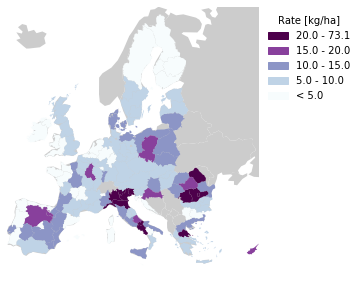

In [16]:
# Plot the FADN rates
plot_rate_choropleth(fadn_rate, fadn_geo, legend=True)

# Distribute FADN quantities to NUTS regions

## First calculate share of each FADN region in each NUTS region

In [17]:
fadn_shares = intersection.get_share(fadn_geo, nuts_geo)
fadn_shares

FADN_2012_  geo 
10          DE      4.304178e-02
            DE6     1.395809e-05
            DE60    1.395809e-05
            DE8     3.571632e-07
            DE80    3.571632e-07
                        ...     
862         HU3     1.554515e-09
            HU33    4.196940e-09
            SI      1.141321e-06
            SI0     1.141321e-06
            SI01    1.903670e-06
Name: share, Length: 1665, dtype: float64

In [18]:
# Sanity check: shares should add up to about 100% in each region
fadn_shares.groupby("geo").sum().describe()

count    390.000000
mean       0.998812
std        0.010287
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [19]:
# FADN zone coverage is evidently not 100% everywhere,
# but it is good in almost all the NUTS regions we use here
fadn_shares.groupby('geo').sum()[candidate_nuts_regions].describe()

count    390.000000
mean       0.998812
std        0.010287
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [20]:
# Let's inspect the NUTS regions with bad coverage
bad_coverage = (
    fadn_shares
    .groupby('geo')
    .sum()
    [candidate_nuts_regions]
    .sort_values()
    .loc[lambda x: x < 0.95]
)
bad_coverage

geo
EL42    0.861934
FR      0.868241
NL      0.949589
Name: share, dtype: float64

## Check that the regions with bad coverage are no real problems

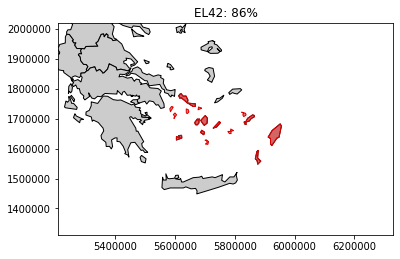

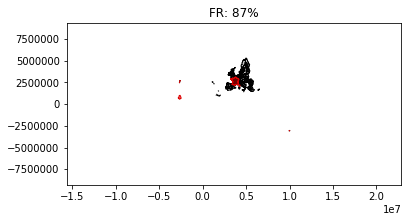

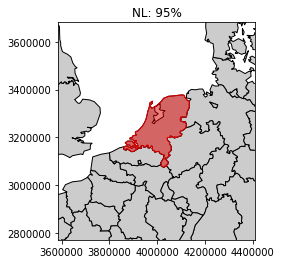

In [21]:
def plot_coverage_case(background, foreground, ax=None):
    ax = background.plot(color='#cccccc', edgecolor='k', ax=ax).axes
    foreground.plot(color='#dd000080', edgecolor='#dd0000', ax=ax)
    xmin, ymin, xmax, ymax = foreground.total_bounds
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin-dx, xmax+dx)
    ax.set_ylim(ymin-dy, ymax+dy)
    return ax

for k, v in bad_coverage.items():
    ax = plot_coverage_case(fadn_geo, nuts_geo.loc[[k]])
    ax.set_title(f'{k}: {v:.0%}')

In [22]:
# To deal with the few NUTS regions that are poorly covered,
# calculate weights that by definition add up to 100% in each NUTS region.
# To avoid any mistakes, let's only include the NUTS regions used in this analysis.
fadn_weights = (
    fadn_shares
    .groupby('geo')
    .apply(lambda s: s / s.sum())
    .loc[:, candidate_nuts_regions]
)
fadn_weights.groupby('geo').sum().describe().round(5)

count    390.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [23]:
fadn_weights.to_csv(settings.FADN_WEIGHTS_PATH, header=True)

## Calculate FADN rates and quantities in NUTS regions using weights

In [24]:
fadn_rate_nuts = (
    fadn_rate
    .rename_axis('FADN_2012_')
    .mul(fadn_weights)
    .groupby('geo')
    .sum()
    .rename('rate')
)

fadn_rate_nuts

geo
AT      5.675903
AT1     5.675905
AT11    5.675928
AT12    5.675901
AT13    5.675897
          ...   
UKM3    5.436145
UKM5    5.436145
UKM6    5.436145
UKN     3.009187
UKN0    3.009187
Name: rate, Length: 390, dtype: float64

In [25]:
fadn_quantity_nuts = fadn_rate_nuts * uaa
fadn_quantity_nuts

geo
AT      15.477562
AT1      6.236911
AT11     1.032849
AT12     5.158542
AT13     0.045521
          ...    
UKM3     4.339892
UKM5     2.602663
UKM6    15.023113
UKN      3.148030
UKN0     3.148030
Length: 427, dtype: float64

# Inspect the subnational datasets

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


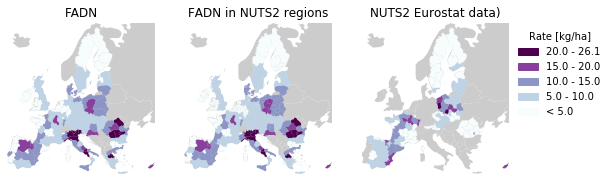

In [26]:
datasets = [
    dict(
        title='FADN',
        rate=fadn_rate,
        geo=fadn_geo,        
    ),
    dict(
        title='FADN in NUTS2 regions',
        rate=nuts.filter_nuts_level(fadn_rate_nuts, 2),
        geo=nuts_geo,
    ),
    dict(
        title='NUTS2 Eurostat data)',
        rate=nuts.filter_nuts_level(usefert_rate, 2),
        geo=nuts_geo,
    )
]

fig = plot_multiple(datasets)

# Load and compare national P rates from different sources

In [27]:
manfert_quantity = (
    eust
    .read_table_data('aei_fm_manfert', version='2019-03-01 11:00:00')
    .value
    .xs(settings.DATA_YEAR, level='time')
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e-3) # to Gg P
    .pipe(nuts.fill_nuts)
    .rename('manfert')
)

eurostat_gnb_quantity = (
    eust
    .read_table_data('aei_pr_gnb')
    .value
    .xs(settings.DATA_YEAR, level='time')
    .xs('P', level='nutrient')
    .xs('I_FRT_MIN', level='indic_ag')
    .div(1e3) # to Gg P
    .rename('GNB')
)

all_totals = (
    pd.concat([usefert_quantity, manfert_quantity, eurostat_gnb_quantity], axis=1)
    .dropna()
)
all_totals

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,usefert,manfert,GNB
AT,14.234,17.261,17.261
BG,11.656,22.758,11.656
CY,1.945,0.801,0.801
CZ,18.201,17.784,18.201
DE,124.073,124.022,124.073
DK,12.300,13.601,13.601
EE,3.129,4.534,3.129
EL,25.896,25.523,25.523
ES,189.014,186.740,188.928
FI,11.184,10.468,11.184


## Calculate and plot relative difference (manfert - usefert) / usefert

BG    0.952471
CY   -0.588175
EE    0.449025
IT   -0.667122
LV   -0.527741
NL    0.502008
dtype: float64

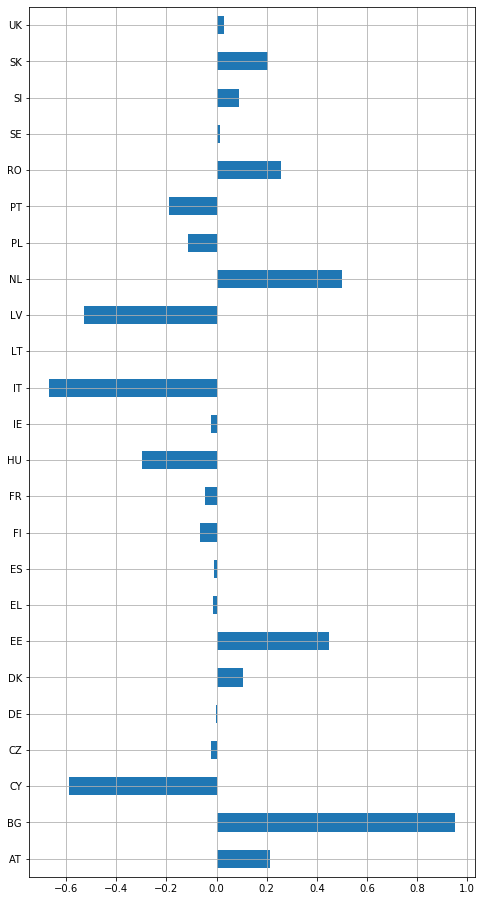

In [28]:
reldiff = all_totals.eval('(manfert - usefert) / usefert')

# List countries with large relative differences
display(reldiff[reldiff.abs() > .3])

ax = reldiff.plot.barh(figsize=(8, 16)).axes
ax.grid(True)

# Rescale quantities to agree with the Eurostat GNB national totals

In [29]:
def rescale_to_national(to_rescale, national):
    # Calculate national sums of to_rescale on each NUTS level
    sums = (
        nuts_table
        .join(to_rescale.rename('value'), how='inner')
        .groupby(['country_code', 'nuts_level'])
        .sum()
        .value
    )
    
    # Get the desired national sums on national level
    national = nuts.filter_nuts_level(national, 0).rename_axis('country_code')
    
    scale_factors = national / sums
    
    # Join to_rescale with the scale factors and multiply
    rescaled = (
        nuts_table
        .join(to_rescale.rename('value'), how='inner')
        .join(scale_factors.rename('scale'), on=['country_code', 'nuts_level'])
        .eval('scale * value')
        .rename(to_rescale.name)
    )
    
    return rescaled

In [30]:
# Choose the GNB national totals

national_quantity = eurostat_gnb_quantity
national_rate = national_quantity.div(uaa).dropna()

In [31]:
usefert_quantity_rescaled = rescale_to_national(usefert_quantity, national_quantity)
usefert_rate_rescaled = usefert.div(uaa).dropna()
fadn_quantity_nuts_rescaled = rescale_to_national(fadn_quantity_nuts, national_quantity)
fadn_rate_nuts_rescaled = usefert.div(uaa).dropna()

# Combine  FADN and Eurostat data, preferring Eurostat where available

In [32]:
final_quantity_estimate = (
    usefert_quantity_rescaled
    .reindex(candidate_nuts_regions)
    .fillna(fadn_quantity_nuts_rescaled)
)

final_rate_estimate = final_quantity_estimate.div(uaa).dropna()

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

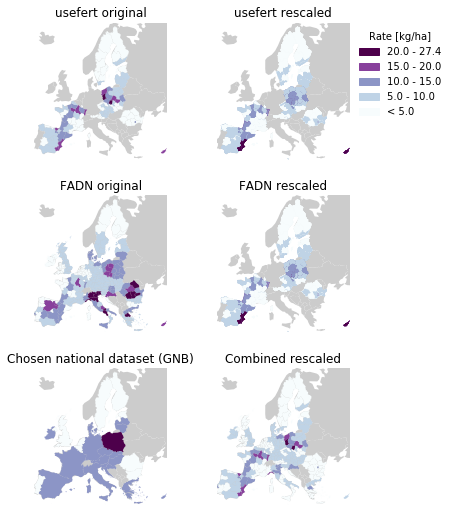

In [33]:
nuts2_geo = nuts.filter_nuts_level(nuts_geo, 2)

fig = plot_multiple(
    [
        dict(rate=usefert_rate, geo=nuts2_geo, title='usefert original'),
        dict(rate=usefert_rate_rescaled, geo=nuts2_geo, title='usefert rescaled'),
        dict(rate=fadn_rate_nuts, geo=nuts2_geo, title='FADN original'),
        dict(rate=fadn_rate_nuts_rescaled, geo=nuts2_geo, title='FADN rescaled'),
        dict(rate=national_rate, geo=nuts_geo, title=f'Chosen national dataset ({national_quantity.name})'),
        dict(rate=final_rate_estimate, geo=nuts2_geo, title='Combined rescaled'),
    ],
    nrows=3,
    ncols=2,
)

fig.savefig('outdata/figures/mineral-steps.pdf', bbox_inches='tight')

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


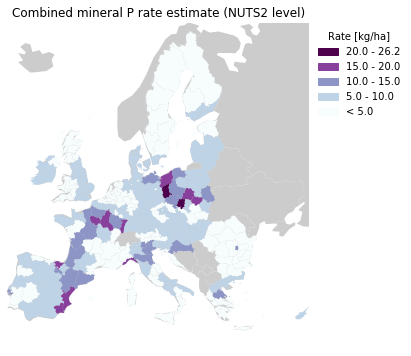

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_rate_choropleth(final_rate_estimate, nuts2_geo, ax=ax)
ax.set_title('Combined mineral P rate estimate (NUTS2 level)')
fig.savefig('outdata/figures/mineral-final.pdf', bbox_inches='tight')

In [35]:
final_quantity_estimate.to_csv(settings.MINERAL_FERTILIZER_PATH, header=True)